## ENPH 353: CLUEBOARD READER NN

November 10, 2025

Ella Majkic

In [39]:
import string
import pandas as pd
import cv2
import random
from sklearn.utils import shuffle
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
print('Success')

Success


Assumption: Able to receive clear, consistent images of clueboards from img topic

In [40]:
!git clone https://github.com/avi-guha/ENPH-353-COMPETITION.git

Cloning into 'ENPH-353-COMPETITION'...
remote: Enumerating objects: 13267, done.
remote: Counting objects: 100% (393/393), done.
remote: Compressing objects: 100% (269/269), done.
remote: Total 13267 (delta 270), reused 205 (delta 123), pack-reused 12874 (from 3)
Receiving objects: 100% (13267/13267), 326.89 MiB | 17.09 MiB/s, done.
Resolving deltas: 100% (1738/1738), done.


In [41]:
%cd ENPH-353-COMPETITION

/content/ENPH-353-COMPETITION


In [42]:
!git checkout clue-board-reading

Updating files: 100% (11816/11816), done.
Branch 'clue-board-reading' set up to track remote branch 'clue-board-reading' from 'origin'.
Switched to a new branch 'clue-board-reading'


Download exact font to run locally to train on correct font:

In [ ]:
!unzip /content/Ubuntu_Mono.zip

unzip:  cannot find or open /content/Ubuntu_Mono.zip, /content/Ubuntu_Mono.zip.zip or /content/Ubuntu_Mono.zip.ZIP.


### 0. Prepare 500 random clueboard prompts - random to mimic nature of comp

---



In [63]:
import csv
import random
import string
import os

# Output path
out_path = "/content/ENPH-353-COMPETITION/cnn_trainer/funny_crimes_500.csv"

ALLOWED = string.ascii_uppercase + string.digits + " "

def clean(x):
    x = x.upper()
    x = "".join(ch for ch in x if ch in ALLOWED)
    return x[:11]  # enforce max 11 chars

# ------------------------------
# 15 OPTIONS PER CATEGORY (<=11 chars each)
# ------------------------------

VICTIMS_BASE = [
    "BEE BROZ", "MUDCREW", "COWCLAN X", "ANT ARMY", "FROG FAM",
    "RATPACKX", "GOAT GANG", "BAT CREW", "MOSS MOB", "SLUG SQUAD",
    "FOXFORCE", "CRAB CREW", "OWL GANG", "WORM CREW", "DUCK DIVZ", "QUAIL Q", "JAGUARJOE"
]

CRIMES_BASE = [
    "POLLHST", "MUD MISCH", "SANDSWIPE", "EGGJSNCH", "JOKEROB",
    "SOUPSTL", "NAPUNAB", "HAT HUVL", "CLDCRIME", "BARK X BG",
    "BUBTHEFT", "LEAFLIFT", "BONKBONK", "CHEESEGRB", "STARZWIP"
]

TIME_BASE = [
    "SUNRISE", "MIDDAY", "NIGHTRUN", "DAWNTIME", "DUSKRUN",
    "NOONRUSH", "MOONHOUR", "STAR TIME", "COSMEVE", "SHADE SHF",
    "CLDCLOCK", "WNDWATCH", "EARTHHR", "TIDETURN", "SOLRSNAP"
]

PLACE_BASE = [
    "EVEREST", "SAHARA", "PACIFIC", "UNXDEZ", "ION CORE",
    "SPACE 99", "MARSDUNE", "LUNARPIT", "PLUTYARD", "FOREST",
    "DEEPPIT X", "COMETCLF", "ATOMTOWN", "NOVANEST", "GALAGATE", "JUPITER"
]

MOTIVE_BASE = [
    "HIVE TAX", "FUN FUND", "SNCKNEED", "RAGEWHY", "BREWQEST",
    "CLDRNT", "MOONDEBT", "CHEELUST", "SALTTHST", "BUBGOAL",
    "STARDUTY", "TURFPRID", "FOAMQEST", "SANDFEUD", "TIMEGAIN"
]

WEAPON_BASE = [
    "BANANAZ", "MEGAMOP", "FOAMGUN", "GLOOPRAY", "ICEBOMB",
    "SPDSTICK", "NOODWHIP", "CLDHAMR", "BUBBLADE", "SNDSABER",
    "LEAFLNC", "MUDMISS", "WNDWAND", "CHEEAXE", "STASLNG V"
]

BANDIT_BASE = [
    "YAK KIDX", "FOXXX AD", "MUNKMAN", "GOATGAL J", "SLIMEBOT",
    "BUNYBRV", "CRABDUD", "FROGKNG", "ANTKNIT", "OWLBXNDT",
    "RATRGUE", "DUCKUVON", "MOSSMNK", "SLUGLORD", "BEARBARD", "QUEENQQ", "JOKER JO"
]

# Create one CSV row
def make_row():
    return [
        str(random.randint(0, 9)),
        clean(random.choice(VICTIMS_BASE)),
        clean(random.choice(CRIMES_BASE)),
        clean(random.choice(TIME_BASE)),
        clean(random.choice(PLACE_BASE)),
        clean(random.choice(MOTIVE_BASE)),
        clean(random.choice(WEAPON_BASE)),
        clean(random.choice(BANDIT_BASE))
    ]

# Ensure directory exists
os.makedirs(os.path.dirname(out_path), exist_ok=True)

# Write file
with open(out_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["SIZE","VICTIM","CRIME","TIME","PLACE","MOTIVE","WEAPON","BANDIT"])
    for _ in range(500):
        writer.writerow(make_row())

print("Wrote 500 funny crimes to:", out_path)


Wrote 500 funny crimes to: /content/ENPH-353-COMPETITION/cnn_trainer/funny_crimes_500.csv


### 1. Collect perfect clueboard images

---



In [64]:
# Find the path to this script
# Colab-specific:
SCRIPT_PATH = "/content/ENPH-353-COMPETITION/src/enph353/enph353_gazebo/scripts/" #TODO: CHANGE THIS WHEN MOVING TO ROS
# Colab-specific:
OUTPUT_PATH = "/content/ENPH-353-COMPETITION/cnn_trainer/training_data/"# Added for colab training

TEXTURE_PATH = '../media/materials/textures/'

In [70]:
#!/usr/bin/env python3
import cv2
import csv
import numpy as np
import os
import random
import requests
import string

from random import randint
from PIL import Image, ImageFont, ImageDraw

def loadCrimesProfileCompetition():
    '''
    @brief Returns a list of dictionaries (each representing one crime profile)
           and saves all clues to clues.csv.
    '''
    URL = "/content/ENPH-353-COMPETITION/cnn_trainer/funny_crimes_500.csv"

    print("Loading clues ...")
    with open(URL, "r") as f:
        raw = f.read().split('\n')

    # Headers = keys
    key_list = raw[0].split(',')
    value_rows = [r for r in raw[1:] if r.strip()]

    all_clues = []

    # Save all clues to one CSV for reference
    with open(os.path.join(SCRIPT_PATH, "clues.csv"), 'w', newline='') as plates_file:
        csvwriter = csv.writer(plates_file)

        for row in value_rows:
            row_values = row.split(',')
            if len(row_values) != len(key_list):
                continue  # skip malformed rows

            clues = {key: value.upper() for key, value in zip(key_list, row_values)}
            all_clues.append(clues)

            for key, value in clues.items():
                csvwriter.writerow([key, value])

    return all_clues


# Load the banner image
banner_canvas = cv2.imread(os.path.join(SCRIPT_PATH, 'clue_banner.png'))
PLATE_HEIGHT = 600
PLATE_WIDTH = banner_canvas.shape[1]
IMG_DEPTH = 3

# use same font as the ubuntu one to train correctly
font_path = "/content/ENPH-353-COMPETITION/cnn_trainer/UbuntuMono-Regular.ttf"
font_size = 90

# Load all 500 clues
all_clues = loadCrimesProfileCompetition()

print(f"Generating clue images for {len(all_clues)} profiles...")

for idx, clues in enumerate(all_clues):
    row_dir = os.path.join(OUTPUT_PATH, f"crime_{idx+1}")
    os.makedirs(row_dir, exist_ok=True)

    for key, value in clues.items():
        print(f"[{idx+1}] Generating {key}_{value}.png")

        # Convert OpenCV → PIL for text drawing
        blank_plate_pil = Image.fromarray(banner_canvas.copy())
        draw = ImageDraw.Draw(blank_plate_pil)
        font = ImageFont.truetype(font_path, font_size)
        font_color = (255, 0, 0)

        # Draw key/value text
        draw.text((250, 30), key, font_color, font=font)
        draw.text((30, 250), value, font_color, font=font)

        # Convert back to OpenCV image and save
        populated_banner = np.array(blank_plate_pil)
        filename = f"{key}_{value}.png"
        cv2.imwrite(os.path.join(row_dir, filename), populated_banner)

print("All crime profiles processed and saved!")

Loading clues ...
Generating clue images for 500 profiles...
[1] Generating SIZE_2.png
[1] Generating VICTIM_WORM CREW.png
[1] Generating CRIME_POLLHST.png
[1] Generating TIME_DAWNTIME.png
[1] Generating PLACE_SAHARA.png
[1] Generating MOTIVE_BUBGOAL.png
[1] Generating WEAPON_NOODWHIP.png
[1] Generating BANDIT_FROGKNG.png
[2] Generating SIZE_3.png
[2] Generating VICTIM_FOXFORCE.png
[2] Generating CRIME_BONKBONK.png
[2] Generating TIME_COSMEVE.png
[2] Generating PLACE_ATOMTOWN.png
[2] Generating MOTIVE_CLDRNT.png
[2] Generating WEAPON_SPDSTICK.png
[2] Generating BANDIT_MOSSMNK.png
[3] Generating SIZE_8.png
[3] Generating VICTIM_BEE BROZ.png
[3] Generating CRIME_JOKEROB.png
[3] Generating TIME_SHADE SHF.png
[3] Generating PLACE_FOREST.png
[3] Generating MOTIVE_TURFPRID.png
[3] Generating WEAPON_STASLNG V.png
[3] Generating BANDIT_MUNKMAN.png
[4] Generating SIZE_2.png
[4] Generating VICTIM_FROG FAM.png
[4] Generating CRIME_LEAFLIFT.png
[4] Generating TIME_CLDCLOCK.png
[4] Generating PLACE

### 2. Extract all disjoint rectangular text blocks

---

In [44]:
board_height = 400
half_height = board_height//2
board_width = 600

Image 1:


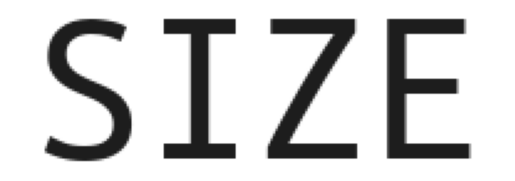

Image 2:


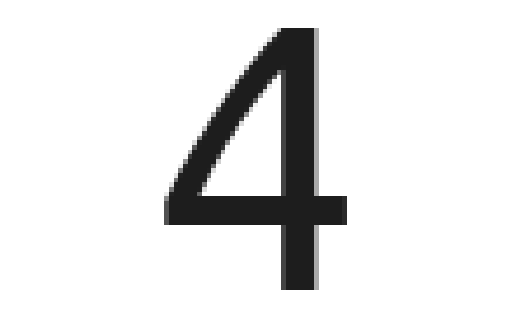

In [45]:
def extract_board_words(board_path):
    """!
    @brief Returns a list of images of each word found in the input board image

    @param board_path: Path to the input board image-
    """
    gray = cv2.imread(board_path, cv2.IMREAD_GRAYSCALE)

    #adaptive threshold - binarize img
    binary = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 10
    )

    # split img into top / bottom
    img_top = binary[0:half_height, :]
    img_bottom = binary[half_height:board_height, :]

    # use different kernel for top / bottom
    # morphological dilation to join nearby characters into words
    kernel_top = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 5))
    dilated_top = cv2.dilate(img_top, kernel_top, iterations=2)

    kernel_bottom = cv2.getStructuringElement(cv2.MORPH_RECT, (35, 5))
    dilated_bottom = cv2.dilate(img_bottom, kernel_bottom, iterations=2)

    # Correctly unpack the result from cv2.findContours()
    contours_top, _ = cv2.findContours(dilated_top, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_bottom, _ = cv2.findContours(dilated_bottom, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # I only want to use second and third contours
    sorted_contours_left = sorted(contours_top, key=lambda c: cv2.boundingRect(c)[0])
    all_contours_top = sorted_contours_left[1:]

    list_top_bottom_word = []

    # debugging
    display_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    for cnt in all_contours_top:
        x, y, w, h = cv2.boundingRect(cnt)
        list_top_bottom_word.append(gray[y:y+h, x:x+w])

        cv2.rectangle(display_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    for cnt in contours_bottom:
        x, y, w, h = cv2.boundingRect(cnt)
        y += half_height  # shift coordinates back to original image
        list_top_bottom_word.append(gray[y:y+h, x:x+w])

        cv2.rectangle(display_img, (x, y), (x+w, y+h), (0, 255, 0), 2)


    #plt.imshow(cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
    #plt.axis('off')
    #plt.show()

    return list_top_bottom_word


# TEST:
board_path = '/content/ENPH-353-COMPETITION/cnn_trainer/training_data/crime_1/SIZE_4.png'
ret = extract_board_words(board_path)

i = 1
for img in ret:
  print("Image " + str(i) + ":")
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()
  i += 1

I am going to need this function later so define it here.
I want all the characters' bounding boxes to be of the same size, so lets pad a set of intake images in this function.

In [46]:
import cv2

def pad_to_max(imgs):
    """
    Pads each image in `imgs` to a fixed size of 90x90 pixels.
    Images are centered and padded with black borders.
    """
    target_height = 90
    target_width = 90

    imgs_padded = []
    for img in imgs:
        height, width = img.shape

        # Compute equal padding on each side
        top = (target_height - height) // 2
        bottom = target_height - height - top

        left = (target_width - width) // 2
        right = target_width - width - left

        padded = cv2.copyMakeBorder(
            img,
            top, bottom, left, right,
            cv2.BORDER_CONSTANT,
            value=[0, 0, 0]
        )
        imgs_padded.append(padded)

    return imgs_padded


Next, I want a function which takes the results of the word extraction and breaks it into characters \(including spaces\)

Width: 90, Height: 90


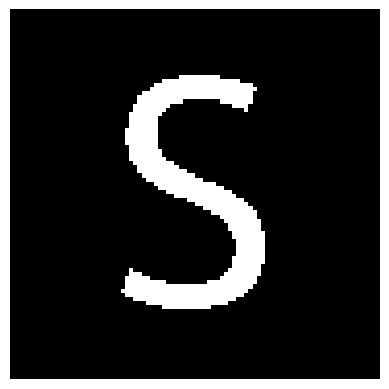

Width: 90, Height: 90


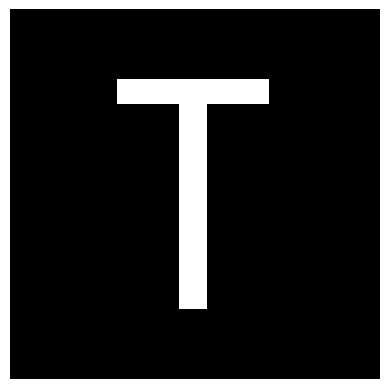

Width: 90, Height: 90


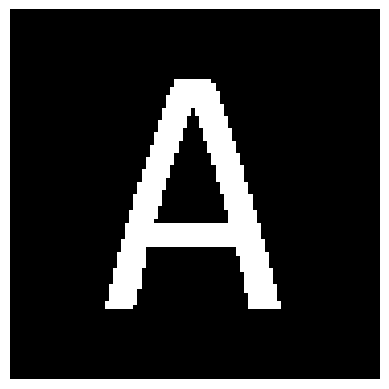

Width: 90, Height: 90


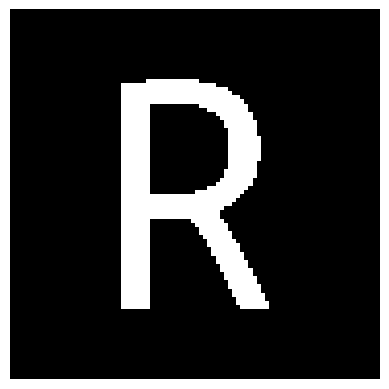

Width: 90, Height: 90


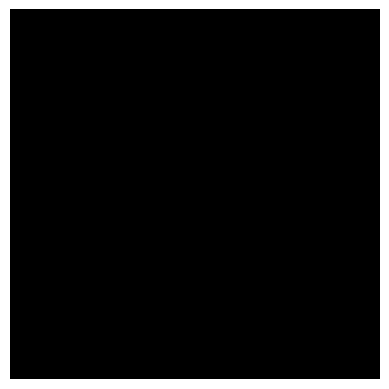

Width: 90, Height: 90


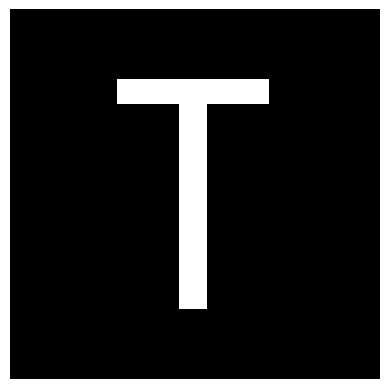

Width: 90, Height: 90


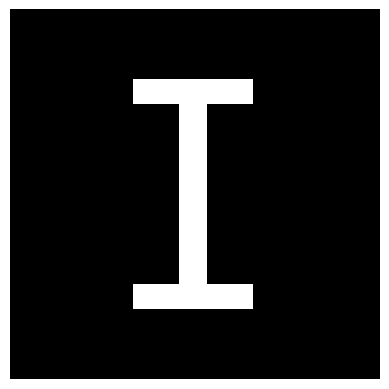

Width: 90, Height: 90


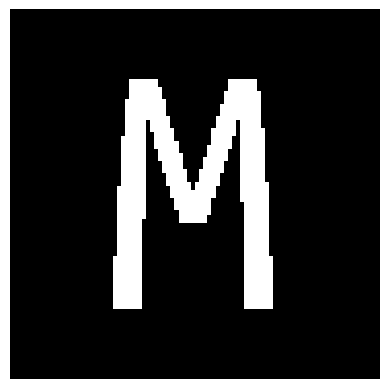

Width: 90, Height: 90


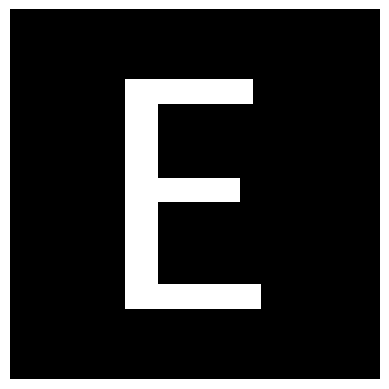

In [47]:
def characterize_word(word_img):
    """!
    @brief Breaks a word image into its constituent characters, including spaces

    @param word_img: A word (gray img) from the result of extract_board_words
    @return: A list of [INVERTED COLOUR] character images containing all characters in the word, including spaces
    """
    vis_img = word_img.copy()

    # threshold the image
    _, thresh = cv2.threshold(word_img, 128, 255, cv2.THRESH_BINARY_INV)

    # Find contours (eachA contour is a letter)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours left-to-right
    contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

    # Crop each letter
    char_images = []
    letter_boxes = []  # temp store coordinates for spacing
    for ctr in contours:
        x, y, w, h = cv2.boundingRect(ctr)
        letter_img = thresh[y:y+h, x:x+w]
        char_images.append(letter_img)
        letter_boxes.append((x, y, w, h))
        cv2.rectangle(vis_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # detect spaces by looking at distances between boxes
    for i in range(len(letter_boxes) - 1):
        x1, y1, w1, h1 = letter_boxes[i]
        x2, y2, w2, h2 = letter_boxes[i+1]
        gap = x2 - (x1 + w1)
        if gap > w1 * 0.5:  # threshold to consider as a space
            # create a blank white image for the space
            space_img = np.zeros((h1, gap), dtype=word_img.dtype)  # black instead of white
            char_images.insert(i+1, space_img)  # insert at correct position
            cv2.rectangle(vis_img, (x1 + w1, y1),
                          (x1 + w1 + gap, y1 + h1), (0, 0, 255), 2)  # red for spaces

    # Display the image with bounding boxes
    #plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    #plt.axis('off')
    #plt.show()

    padded_char_images = pad_to_max(char_images)

    return padded_char_images

# TEST:
board_path = '/content/ENPH-353-COMPETITION/cnn_trainer/training_data/crime_1/TIME_STAR TIME.png'
words_found = extract_board_words(board_path)

chars_word1 = characterize_word(words_found[1])
for char in chars_word1:
  plt.imshow(cv2.cvtColor(char, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  height, width = char.shape
  print(f"Width: {width}, Height: {height}")
  plt.show()

### 4. DataGen
---

For each image in training_data, I will use keras ImageDataGenerator to create some more realistic images.

In [81]:
def datagen_img(img_path, num_to_gen):
    """!
    @brief Generates augmented versions of an image and saves them training_data_img_gen folder

    @param img_path: Path to the input image
    @param num_to_gen: Number of images to generate
    """

    save_dir = "/content/ENPH-353-COMPETITION/cnn_trainer/training_data_img_gen/"

    # Extract the image name without extension (e.g., "cat" from "cat.jpg")
    img_name = os.path.splitext(os.path.basename(img_path))[0]

    img = np.array(Image.open(img_path))

    datagen = ImageDataGenerator(
        rotation_range=5,
        zoom_range=0.09,
        brightness_range=[0.7, 1.2],
        shear_range=0.04,
        fill_mode='nearest'
    )

    # load the input image as arr
    image_array = np.expand_dims(img, 0)
    datagen_iterator = datagen.flow(image_array, batch_size=1)

    # Generate and save augmented images
    for j in range(num_to_gen):
        value = next(datagen_iterator)
        gen_img = value[0].astype('uint8')
        pil_img = Image.fromarray(gen_img)

        # save with the same base name + index
        filename = f"{img_name}.png"
        file_path = os.path.join(save_dir, filename)
        pil_img.save(file_path)

Now go through all perfect imgs and save datagen version:

#### ONLY DATAGEN ONCE
\(it takes so long \)

In [82]:
base_dir = "/content/ENPH-353-COMPETITION/cnn_trainer/training_data/"

for crime in os.listdir(base_dir):
    crime_path = os.path.join(base_dir, crime)

    for clueboard in os.listdir(crime_path):
        clueboard_path = os.path.join(crime_path, clueboard)
        datagen_img(clueboard_path, 1)

Test:

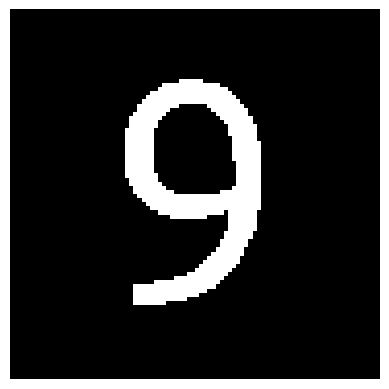

In [83]:
# TEST:
board_path = '/content/ENPH-353-COMPETITION/cnn_trainer/training_data_img_gen/SIZE_9.png'
words_found = extract_board_words(board_path)

chars_word1 = characterize_word(words_found[1])
for char in chars_word1:
  plt.imshow(cv2.cvtColor(char, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

### 5. Assemble all characters for training
---

In [84]:
perfect_data_dir = "/content/ENPH-353-COMPETITION/cnn_trainer/training_data/"
gen_data_dir     = "/content/ENPH-353-COMPETITION/cnn_trainer/training_data_img_gen/"

output_dir = "/content/ENPH-353-COMPETITION/cnn_trainer/training_chars/"
os.makedirs(output_dir, exist_ok=True)

char_counters = {}

def process_clueboards(clueboard_files):
    for clueboard_path in clueboard_files:
        clueboard_file = os.path.basename(clueboard_path)

        # Words from filename (e.g. SIZE_9 → ["SIZE", "9"])
        clueboard_name = os.path.splitext(clueboard_file)[0]
        words_in_filename = clueboard_name.split('_')

        # Extract detected word regions from the image
        word_imgs = extract_board_words(clueboard_path)

        # Number of pairs we can process
        paired_count = min(len(words_in_filename), len(word_imgs))

        # -----------------------------------------------------------
        # 1. Process filename-word pairs where image + filename exist
        # -----------------------------------------------------------
        for i in range(paired_count):
            word_str = words_in_filename[i]
            word_img = word_imgs[i]

            # -------------------------------------------------------
            # CASE A: SINGLE-DIGIT WORD → DO NOT SEGMENT
            # Save entire word_img as the digit
            # -------------------------------------------------------
            if len(word_str) == 1 and word_str.isdigit():
                char_label = word_str  # '0'..'9'

                img = word_img  # Entire bounding box is the digit

                count = char_counters.get(char_label, 0) + 1
                char_counters[char_label] = count

                filename = f"{char_label}_{count}.png"
                Image.fromarray(img).save(os.path.join(output_dir, filename))
                continue  # Skip segmentation entirely

            # -------------------------------------------------------
            # CASE B: NORMAL WORD → SEGMENT INTO CHARACTERS
            # -------------------------------------------------------
            char_imgs = characterize_word(word_img)
            min_chars = min(len(char_imgs), len(word_str))

            for j in range(min_chars):
                # Normal letter label
                char_label = word_str[j].upper()

                img = char_imgs[j]

                count = char_counters.get(char_label, 0) + 1
                char_counters[char_label] = count

                filename = f"{char_label}_{count}.png"
                Image.fromarray(img).save(os.path.join(output_dir, filename))

        # -------------------------------------------------------------------
        # 2. Process leftover filename entries (digit in filename but no image)
        # -------------------------------------------------------------------
        for k in range(paired_count, len(words_in_filename)):
            leftover = words_in_filename[k]

            if len(leftover) == 1 and leftover.isdigit():
                print(f"[WARN] Digit '{leftover}' in {clueboard_file} had no matching image!")
                # Could add fallback detection here if needed.
                continue


# --- Prepare exactly 100 clueboards with all letters A-Z ---

perfect_crime_dirs = [os.path.join(perfect_data_dir, d) for d in os.listdir(perfect_data_dir) if os.path.isdir(os.path.join(perfect_data_dir, d))]

# Flatten all clueboard files
all_clueboards = []
for crime_dir in perfect_crime_dirs:
    for f in os.listdir(crime_dir):
        file_path = os.path.join(crime_dir, f)
        if os.path.isfile(file_path):
            all_clueboards.append(file_path)

random.shuffle(all_clueboards)  # shuffle

letters_needed = set("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
selected_clueboards = []

# Step 1: pick boards that contain any missing letters until all letters covered
for cb in all_clueboards:
    filename_letters = set(''.join(os.path.splitext(os.path.basename(cb))[0].split('_')).upper())
    if letters_needed & filename_letters:
        selected_clueboards.append(cb)
        letters_needed -= filename_letters
    if not letters_needed:
        break

# Step 2: fill remaining slots randomly to reach exactly 100 boards
remaining = [cb for cb in all_clueboards if cb not in selected_clueboards]
while len(selected_clueboards) < 100:
    selected_clueboards.append(remaining.pop())

# Ensure exactly 100
selected_clueboards = selected_clueboards[:100]

process_clueboards(selected_clueboards)

# --- Process all clueboards from data gen folder ---
gen_clueboards = [os.path.join(gen_data_dir, f) for f in os.listdir(gen_data_dir) if os.path.isfile(os.path.join(gen_data_dir, f))]
process_clueboards(gen_clueboards)


In [87]:
%cd ../training_chars/

/content/ENPH-353-COMPETITION/cnn_trainer/training_chars


### 6. One-hot encoding, data prep
---

In [89]:
classes = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 " # class 36 is just a space, ' '
char_to_idx = {c: i for i, c in enumerate(classes)}
print(char_to_idx)

idx_to_char = {i: c for i, c in enumerate(classes)}
print(idx_to_char)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, '0': 26, '1': 27, '2': 28, '3': 29, '4': 30, '5': 31, '6': 32, '7': 33, '8': 34, '9': 35, ' ': 36}
{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: '0', 27: '1', 28: '2', 29: '3', 30: '4', 31: '5', 32: '6', 33: '7', 34: '8', 35: '9', 36: ' '}


In [90]:
IMG_SIZE = 90

In [91]:
X = []  # images array
y = []  # corresponding labels
IMG_SIZE = 90

data_dir = "/content/ENPH-353-COMPETITION/cnn_trainer/training_chars/"

for filename in os.listdir(data_dir):
    if filename.endswith(".png"):
        char_label = filename.split("_")[0]
        char_img = cv2.imread(os.path.join(data_dir, filename), cv2.IMREAD_GRAYSCALE)# read in greyscale
        char_img = cv2.resize(char_img, (IMG_SIZE, IMG_SIZE))
        char_img_normal = char_img.astype("float32") / 255.0 # normalize

        X.append(char_img_normal)
        y.append(char_label)

X = np.array(X)

# convert to indices from our dictionary
y_int = np.array([char_to_idx[c] for c in y])


# convert to one hot
num_classes = len(classes)
y_total = keras.utils.to_categorical(y_int, num_classes=num_classes)

# shuffle for randomness
X_total, y_total = shuffle(X, y_total, random_state=42)

### 7. Define Model

---

In [92]:
# Tune param as needed
epochs = 32
batch_size = 64
learning_rate = 0.001
val_split=0.2 # % of data to be used as validation

In [93]:
#Check shape to determine input shape to model
print(X_total.shape)
input_shape=(IMG_SIZE , IMG_SIZE, 1) # save input shape as var

(2693, 90, 90)


In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

input_shape = (90, 90, 1)
num_classes = 37  # A-Z + 0-9 + space

model = Sequential([
    Input(shape=input_shape),  # <- Keras 3 style, NO batch_shape

    Conv2D(32, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 90, 90, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 90, 90, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 45, 45, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 22, 22, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 22, 22, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 22, 22, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,982,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 37)             │         9,509 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,131,717 (8.13 MB)

 Trainable params: 2,131,397 (8.13 MB)

 Non-trainable params: 320 (1.25 KB)

In [96]:
model.compile(optimizer='adam', # as discussed in class
              loss='categorical_crossentropy', # for multiple classes
              metrics=['accuracy'])

In [97]:
history = model.fit(X_total,
                    y_total,
                    batch_size=batch_size, # defined above
                    epochs=epochs, # defined above
                    verbose=1,
                    validation_split=val_split)

Epoch 1/32
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 363ms/step - accuracy: 0.3160 - loss: 4.4153 - val_accuracy: 0.0167 - val_loss: 3.5461
Epoch 2/32
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8670 - loss: 0.5731 - val_accuracy: 0.0167 - val_loss: 3.9279
Epoch 3/32
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9374 - loss: 0.3132 - val_accuracy: 0.0167 - val_loss: 3.6892
Epoch 4/32
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9287 - loss: 0.3318 - val_accuracy: 0.0167 - val_loss: 3.8581
Epoch 5/32
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9343 - loss: 0.3173 - val_accuracy: 0.0167 - val_loss: 3.8637
Epoch 6/32
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9428 - loss: 0.2877 - val_accuracy: 0.0167 - val_loss: 4.5935
Epoch 7/32
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9503 - loss: 0.2328 - val_accuracy: 0.0167 - val_loss: 3.9395
Epoch 8/32
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9515 - loss: 0.2500 - val_accuracy: 0.0167 -

In [102]:
model.save("/content/ENPH-353-COMPETITION/cnn_trainer/clueboard_reader_CNN.h5")

Test:

In [103]:
loaded_model = keras.models.load_model("/content/ENPH-353-COMPETITION/cnn_trainer/clueboard_reader_CNN.h5")

def predict_board(img_path):
    img = cv2.imread(img_path)

    result = []

    words = extract_board_words(img_path)
    for word_idx, word in enumerate(words):
        chars = characterize_word(word)
        for char in chars:
            # Resize and normalize
            char_img = cv2.resize(char, (IMG_SIZE, IMG_SIZE))
            char_img_normal = char_img.astype("float32") / 255.0

            # Add batch dimension (and channel if needed)
            crop_input = np.expand_dims(char_img_normal, axis=0)

            # Predict character
            prediction = loaded_model.predict(crop_input, verbose=0)
            char_idx = np.argmax(prediction, axis=1)[0]

            result.append(idx_to_char[char_idx])

        # Add a space after each word except the last one
        if word_idx < len(words) - 1:
            result.append(" ")

    return result

# Test on one image
img_path = "/content/ENPH-353-COMPETITION/cnn_trainer/validation_data_img_gen/SIZE_9.png"

print("Predicted board:")
result = predict_board(img_path)

print("".join(result))

Predicted board:
SIZE 9


### Git *Save every time

---

In [106]:
!git config --global user.email "emajkic@student.ubc.ca"
!git config --global user.name "emajkic"

In [ ]:
%cd ENPH-353-COMPETITION/
!git checkout clue-board-reading

In [ ]:
!git add -A
!git commit -m "Retrained model Nov. 30"